# Prediksi Harga Mata Uang Kripto Cardano dengan Metode LSTM (Long Short Term Memory)

## Import Library

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error


## Eksplorasi Data

### Memuat Data


In [27]:
df = pd.read_csv('Data Historis Cardano.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1735 entries, 0 to 1734
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Tanggal     1735 non-null   object
 1   Terakhir    1735 non-null   object
 2   Pembukaan   1735 non-null   object
 3   Tertinggi   1735 non-null   object
 4   Terendah    1735 non-null   object
 5   Vol.        1730 non-null   object
 6   Perubahan%  1735 non-null   object
dtypes: object(7)
memory usage: 95.0+ KB


In [28]:
df.rename(columns={
  'Tanggal': 'Date',
  'Terakhir': 'Close',
  'Pembukaan': 'Open',
  'Tertinggi': 'High',
  'Terendah': 'Low',
  'Vol.': 'Volume',
  'Perubahan%': 'Change'
}, inplace=True)

df.head()

,Date,Close,Open,High,Low,Volume,Change
0,30/09/2024,"0,3734","0,3976","0,3976","0,3709","143,27M","-6,07%"
1,29/09/2024,"0,3976","0,4006","0,4041","0,3927","89,35M","-0,74%"
2,28/09/2024,"0,4006","0,4017","0,4058","0,3924","102,69M","-0,27%"
3,27/09/2024,"0,4017","0,4016","0,4153","0,3999","148,17M","0,00%"
4,26/09/2024,"0,4016","0,3811","0,4037","0,3782","165,03M","5,38%"


### Mengubah Tipe Data

In [29]:
df['Change'] = df['Change'].str.replace('%', '').str.replace(',', '.').astype(float)
df.head()

,Date,Close,Open,High,Low,Volume,Change
0,30/09/2024,"0,3734","0,3976","0,3976","0,3709","143,27M",-6.07
1,29/09/2024,"0,3976","0,4006","0,4041","0,3927","89,35M",-0.74
2,28/09/2024,"0,4006","0,4017","0,4058","0,3924","102,69M",-0.27
3,27/09/2024,"0,4017","0,4016","0,4153","0,3999","148,17M",0.00
4,26/09/2024,"0,4016","0,3811","0,4037","0,3782","165,03M",5.38


In [30]:
df['Volume'] = df['Volume'].str.replace('M', 'e6').str.replace('B', 'e9').str.replace(',', '.').astype(float)
df['Close'] = df['Close'].str.replace(',', '.').astype(float)
df['Open'] = df['Open'].str.replace(',', '.').astype(float)
df['High'] = df['High'].str.replace(',', '.').astype(float)
df['Low'] = df['Low'].str.replace(',', '.').astype(float)
df['Change'] = df['Change'].astype(float)

df.head()

,Date,Close,Open,High,Low,Volume,Change
0,30/09/2024,0.3734,0.3976,0.3976,0.3709,143270000.0,-6.07
1,29/09/2024,0.3976,0.4006,0.4041,0.3927,89350000.0,-0.74
2,28/09/2024,0.4006,0.4017,0.4058,0.3924,102690000.0,-0.27
3,27/09/2024,0.4017,0.4016,0.4153,0.3999,148170000.0,0.00
4,26/09/2024,0.4016,0.3811,0.4037,0.3782,165030000.0,5.38


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1735 entries, 0 to 1734
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1735 non-null   object 
 1   Close   1735 non-null   float64
 2   Open    1735 non-null   float64
 3   High    1735 non-null   float64
 4   Low     1735 non-null   float64
 5   Volume  1730 non-null   float64
 6   Change  1735 non-null   float64
dtypes: float64(6), object(1)
memory usage: 95.0+ KB


### Imputasi Missing Values

In [32]:
df.isnull().sum()

Date      0
Close     0
Open      0
High      0
Low       0
Volume    5
Change    0
dtype: int64

In [33]:
imputer = KNNImputer(n_neighbors=2)
df_imputed = df.copy()
df_imputed[['Volume']] = imputer.fit_transform(df[['Volume']])

df = df_imputed

df.isnull().sum()

Date      0
Close     0
Open      0
High      0
Low       0
Volume    0
Change    0
dtype: int64

### Visualisasi Data

#### Pergerakan Harga Pembukaan

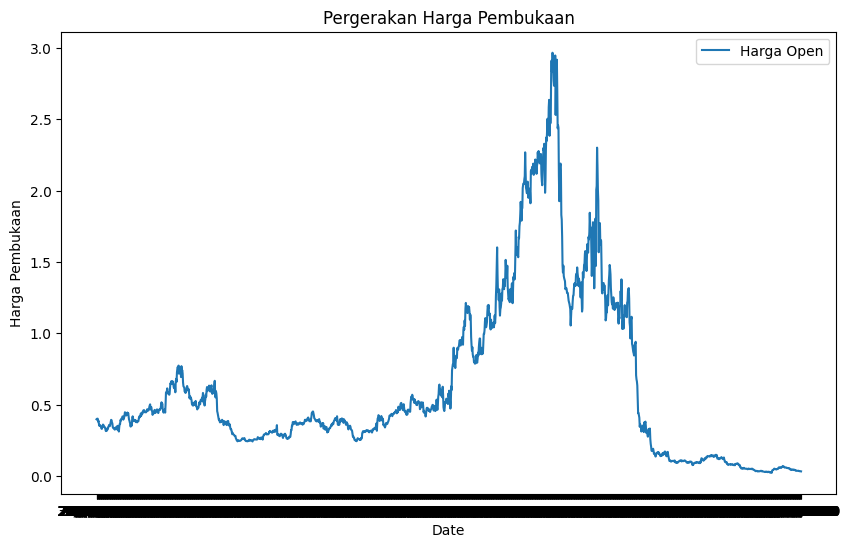

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Open'], label='Harga Open')
plt.xlabel('Date')
plt.ylabel('Harga Pembukaan')
plt.title('Pergerakan Harga Pembukaan')
plt.legend()
plt.show()

#### Pergerakan Harga Penutupan

/tmp/ipykernel_6480/3655211889.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_bulanan = df.resample('M').last()


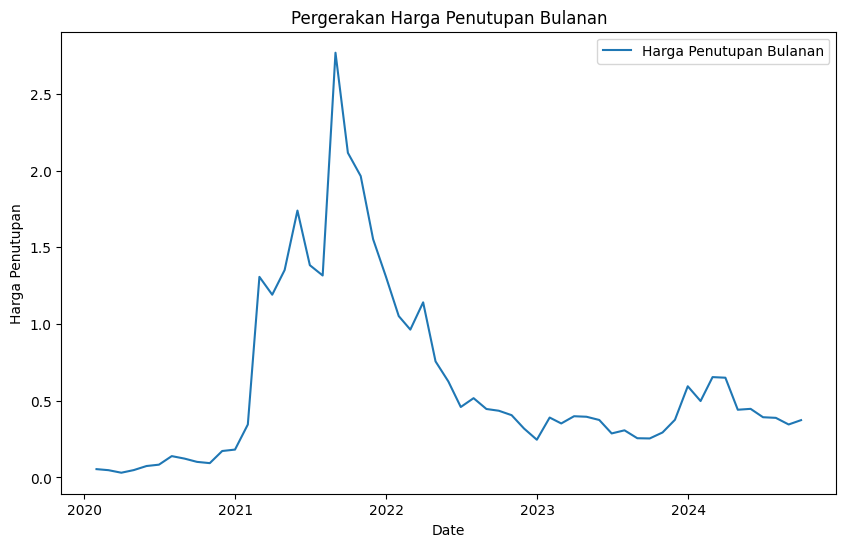

In [35]:
# Mengubah kolom 'Date' menjadi tipe datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# Mengatur 'Date' sebagai index
df.set_index('Date', inplace=True)

# Mengubah data harian menjadi data bulanan dengan mengambil harga penutupan terakhir setiap bulan
df_bulanan = df.resample('M').last()

# Plot harga penutupan bulanan
plt.figure(figsize=(10, 6))
plt.plot(df_bulanan.index, df_bulanan['Close'], label='Harga Penutupan Bulanan')
plt.xlabel('Date')
plt.ylabel('Harga Penutupan')
plt.title('Pergerakan Harga Penutupan Bulanan')
plt.legend()
plt.show()

#### Harga Penutupan MA 30

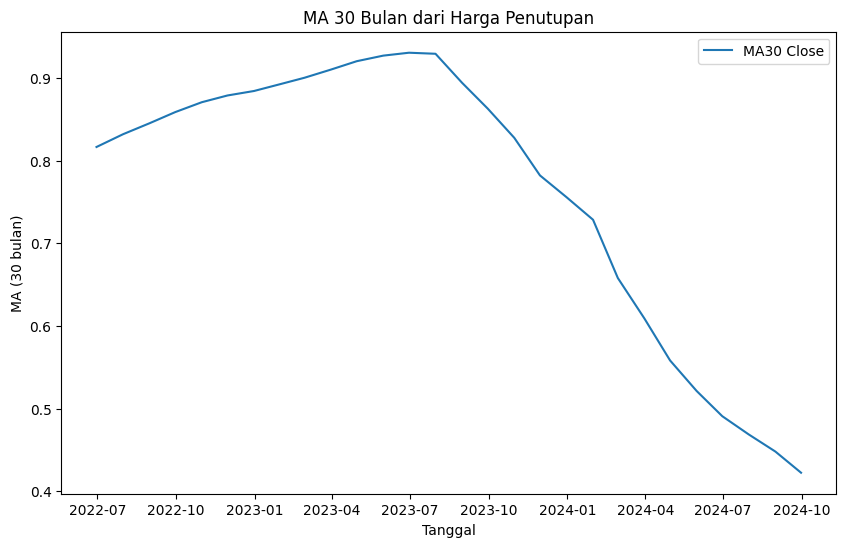

In [36]:
# Menghitung rata-rata bergerak (MA) untuk jendela 30 bulan
df_bulanan['MA30_Close'] = df_bulanan['Close'].rolling(window=30).mean()

# Plot rata-rata bergerak
plt.figure(figsize=(10, 6))
plt.plot(df_bulanan.index, df_bulanan['MA30_Close'], label='MA30 Close')
plt.xlabel('Tanggal')
plt.ylabel('MA (30 bulan)')
plt.title('MA 30 Bulan dari Harga Penutupan')
plt.legend()
plt.show()

#### Harga Pembukaan MA 30

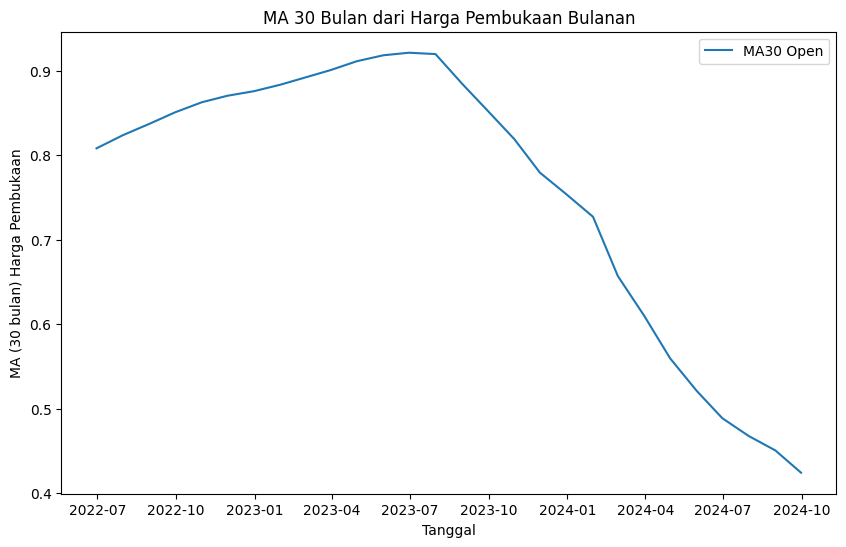

In [37]:
# Mengubah data harian menjadi data bulanan dengan mengambil harga pembukaan terakhir setiap bulan
df_bulanan['MA30_Open'] = df_bulanan['Open'].rolling(window=30).mean()

# Plot rata-rata bergerak harga pembukaan bulanan
plt.figure(figsize=(10, 6))
plt.plot(df_bulanan.index, df_bulanan['MA30_Open'], label='MA30 Open')
plt.xlabel('Tanggal')
plt.ylabel('MA (30 bulan) Harga Pembukaan')
plt.title('MA 30 Bulan dari Harga Pembukaan Bulanan')
plt.legend()
plt.show()

#### Volatilitas Harian

/tmp/ipykernel_6480/142378207.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_bulanan['Volatilitas_Bulanan'] = df['daily_volatility'].resample('M').last()


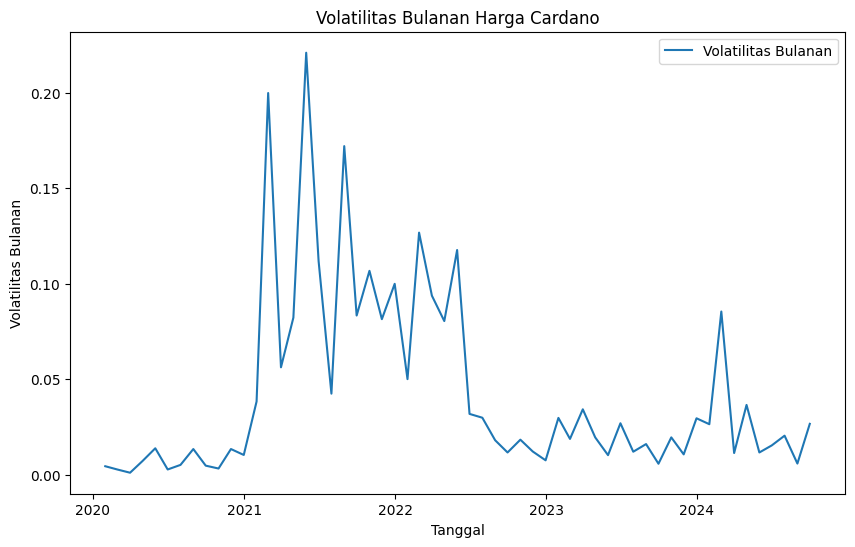

In [38]:
# Menambahkan kolom volatilitas harian
df['daily_volatility'] = df['High'] - df['Low']

# Mengubah data harian menjadi data bulanan dengan mengambil volatilitas harian terakhir setiap bulan
df_bulanan['Volatilitas_Bulanan'] = df['daily_volatility'].resample('M').last()

# Plot volatilitas bulanan
plt.figure(figsize=(10, 6))
plt.plot(df_bulanan.index, df_bulanan['Volatilitas_Bulanan'], label='Volatilitas Bulanan')
plt.xlabel('Tanggal')
plt.ylabel('Volatilitas Bulanan')
plt.title('Volatilitas Bulanan Harga Cardano')
plt.legend()
plt.show()

#### Volume Perdangan

/tmp/ipykernel_6480/1629643273.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_bulanan['Volume_Bulanan'] = df['Volume'].resample('M').sum()


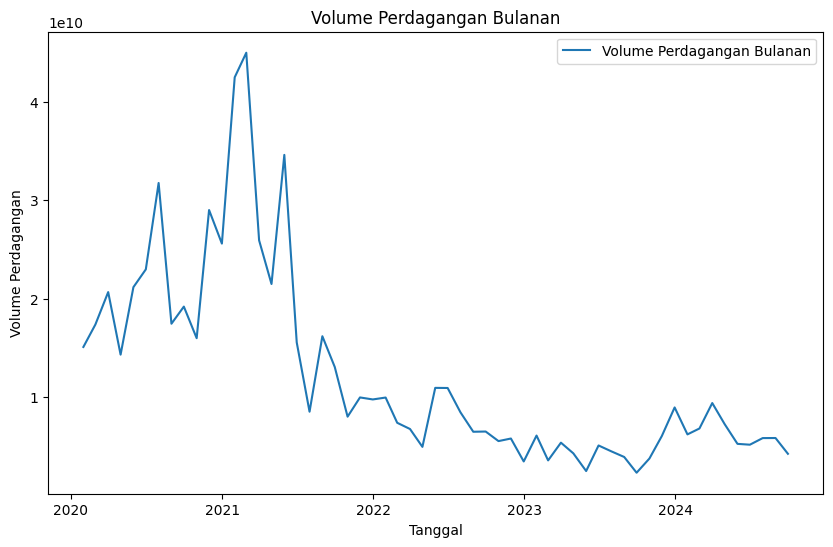

In [39]:
# Mengubah data harian menjadi data bulanan dengan menjumlahkan volume perdagangan setiap bulan
df_bulanan['Volume_Bulanan'] = df['Volume'].resample('M').sum()

# Plot volume perdagangan bulanan
plt.figure(figsize=(10, 6))
plt.plot(df_bulanan.index, df_bulanan['Volume_Bulanan'], label='Volume Perdagangan Bulanan')
plt.xlabel('Tanggal')
plt.ylabel('Volume Perdagangan')
plt.title('Volume Perdagangan Bulanan')
plt.legend()
plt.show()

### Korelasi Antar Variabel

                     Close      Open      High       Low    Volume    Change  \
Close             1.000000  0.996477  0.998657  0.997674  0.046408  0.012080   
Open              0.996477  1.000000  0.998114  0.996847  0.041480 -0.048996   
High              0.998657  0.998114  1.000000  0.996172  0.061832 -0.012594   
Low               0.997674  0.996847  0.996172  1.000000  0.016858 -0.015539   
Volume            0.046408  0.041480  0.061832  0.016858  1.000000  0.156332   
Change            0.012080 -0.048996 -0.012594 -0.015539  0.156332  1.000000   
daily_volatility  0.729242  0.730996  0.751674  0.691147  0.384033  0.013115   

                  daily_volatility  
Close                     0.729242  
Open                      0.730996  
High                      0.751674  
Low                       0.691147  
Volume                    0.384033  
Change                    0.013115  
daily_volatility          1.000000  


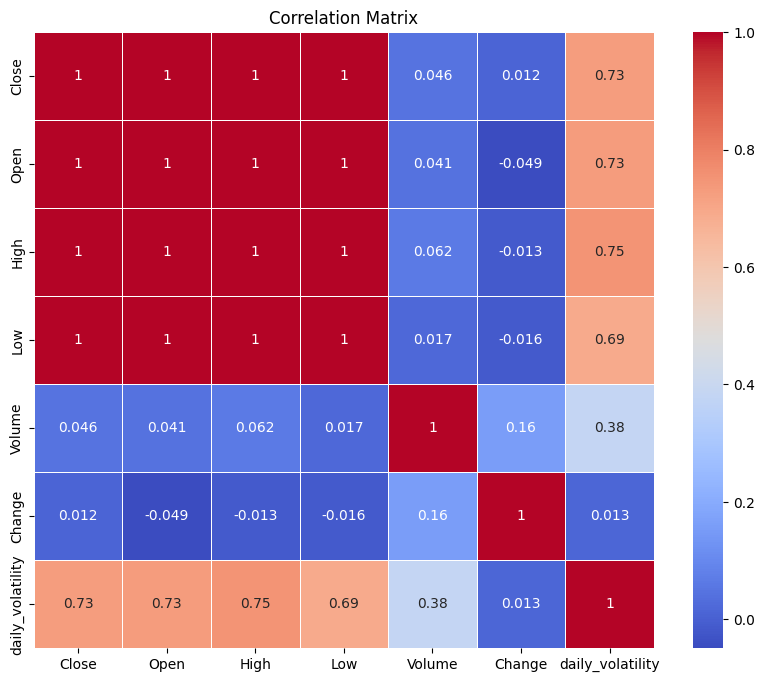

In [40]:
correlation_matrix = df.corr()

print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Pre-Processing Data

#### Seleksi Fitur

In [41]:
df.drop(columns=['Change', 'Volume'], inplace=True)
df.head()

,Close,Open,High,Low,daily_volatility
Date,,,,,
2024-09-30,0.3734,0.3976,0.3976,0.3709,0.0267
2024-09-29,0.3976,0.4006,0.4041,0.3927,0.0114
2024-09-28,0.4006,0.4017,0.4058,0.3924,0.0134
2024-09-27,0.4017,0.4016,0.4153,0.3999,0.0154
2024-09-26,0.4016,0.3811,0.4037,0.3782,0.0255


#### Penanganan Outlier

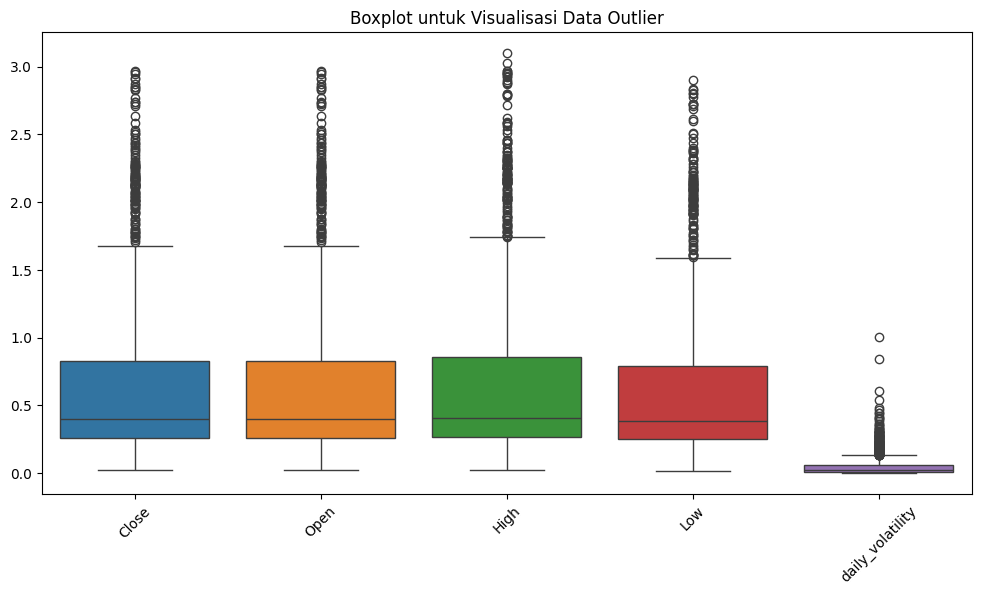

In [42]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Close', 'Open', 'High', 'Low', 'daily_volatility']])
plt.title('Boxplot untuk Visualisasi Data Outlier')
plt.xticks(rotation=45)
plt.show()

#### Normaliasi Data dengan Min-Max Scaling

### Alokasi Data Training dan Testing

## Modelling

/home/wchynto/media/data/Personal/Kuliah/PSD/prediksi-harga-cardano/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 306ms/step - loss: 0.0339 - val_loss: 4.2474e-05
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 288ms/step - loss: 0.0041 - val_loss: 1.6050e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 278ms/step - loss: 0.0034 - val_loss: 6.9091e-05
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 304ms/step - loss: 0.0034 - val_loss: 2.2788e-05
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 279ms/step - loss: 0.0030 - val_loss: 4.6579e-05
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step - loss: 0.0031 - val_loss: 1.1587e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 280ms/step - loss: 0.0022 - val_loss: 1.0085e-04
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 278ms/step - loss: 0.0026 - val_loss: 1.9608e-05
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 298ms/step - loss: 0.0035 - val_loss: 1.8449e-05
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 276ms/step - loss: 0.0021 - val_loss: 1.5693e-05
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 276ms/step - loss: 0.0026 - val_loss: 1.3316e-

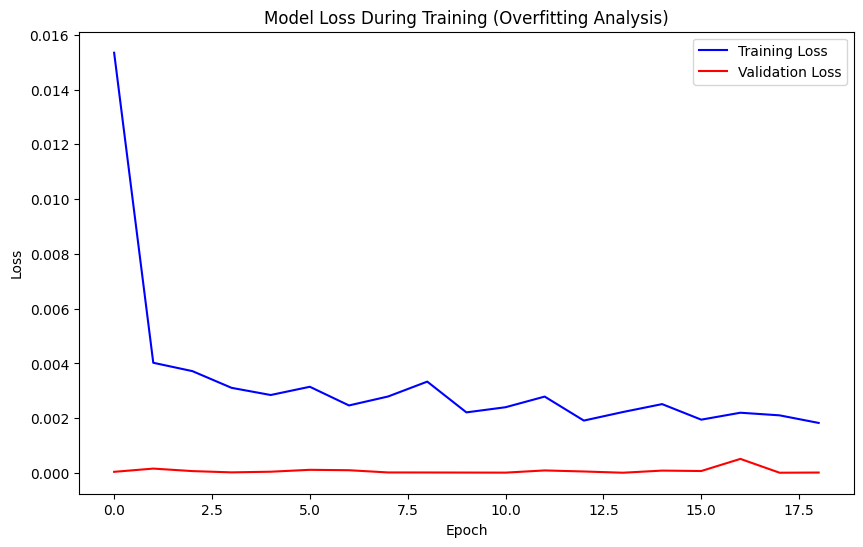

  0%|          | 0/30 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step


  3%|▎         | 1/30 [00:00<00:24,  1.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  7%|▋         | 2/30 [00:01<00:12,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 10%|█         | 3/30 [00:01<00:08,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 13%|█▎        | 4/30 [00:01<00:06,  3.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 17%|█▋        | 5/30 [00:01<00:05,  4.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 20%|██        | 6/30 [00:01<00:04,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 23%|██▎       | 7/30 [00:01<00:04,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 27%|██▋       | 8/30 [00:01<00:03,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 30%|███       | 9/30 [00:02<00:03,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 33%|███▎      | 10/30 [00:02<00:03,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 37%|███▋      | 11/30 [00:02<00:03,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 40%|████      | 12/30 [00:02<00:03,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 43%|████▎     | 13/30 [00:02<00:02,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


 47%|████▋     | 14/30 [00:02<00:02,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 50%|█████     | 15/30 [00:03<00:02,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


 53%|█████▎    | 16/30 [00:03<00:02,  4.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 57%|█████▋    | 17/30 [00:03<00:02,  5.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 60%|██████    | 18/30 [00:03<00:02,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 63%|██████▎   | 19/30 [00:03<00:02,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 67%|██████▋   | 20/30 [00:04<00:01,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


 70%|███████   | 21/30 [00:04<00:01,  4.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 73%|███████▎  | 22/30 [00:04<00:01,  5.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 77%|███████▋  | 23/30 [00:04<00:01,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 80%|████████  | 24/30 [00:04<00:00,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 83%|████████▎ | 25/30 [00:05<00:00,  6.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 87%|████████▋ | 26/30 [00:05<00:00,  6.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 90%|█████████ | 27/30 [00:05<00:00,  6.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 93%|█████████▎| 28/30 [00:05<00:00,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 97%|█████████▋| 29/30 [00:05<00:00,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


100%|██████████| 30/30 [00:05<00:00,  5.08it/s]


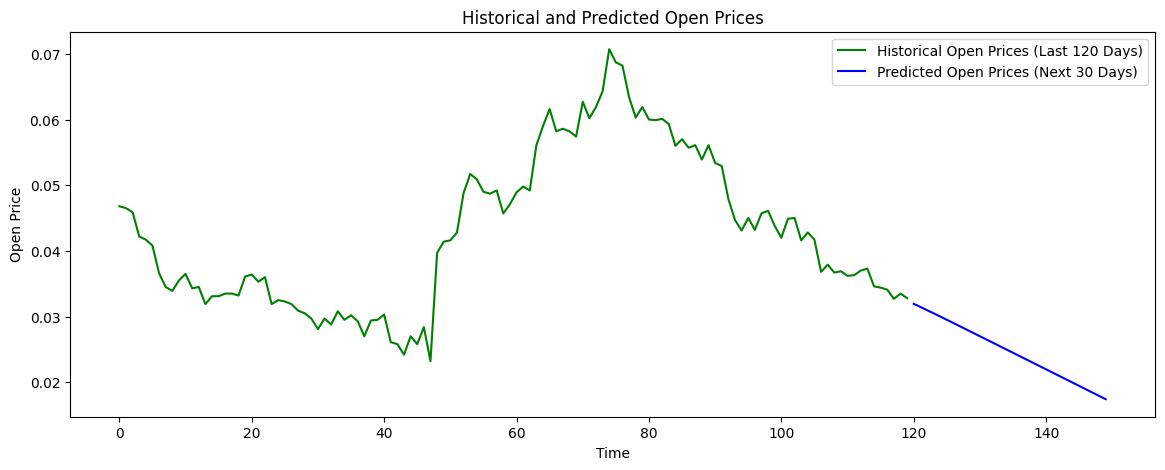

In [72]:
# Preprocessing: Selecting 'Open' column for prediction
data = df[['Open']].values

# Feature scaling (Normalize the data between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define the number of time steps (e.g., 120 days of history)
time_steps = 120
future_days = 30  # We will predict for the next 30 days (1 month)

# Build the LSTM model
model = Sequential()

model.add(LSTM(units=100, return_sequences=True, input_shape=(time_steps, 1)))
model.add(Dropout(0.3))

model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))

model.add(Dense(units=1))

# Compile model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Use EarlyStopping callback to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 1: Create sliding window sequences for training the model
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, time_steps)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM input

# Split into train and test (80% train, 20% test)
split_ratio = 0.8
train_size = int(len(X) * split_ratio)

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Train the model and save the training history
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stop])

# Plot training & validation loss values to analyze overfitting
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss During Training (Overfitting Analysis)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 2: Take the last 120 days from the dataset to make future predictions
last_120_days = scaled_data[-time_steps:]

# Step 3: Predict 30 days iteratively (future_days = 30)
predictions = []
input_sequence = last_120_days

for _ in tqdm(range(future_days)):
    input_sequence_reshaped = np.reshape(input_sequence, (1, time_steps, 1))  # Reshape to (1, 120, 1) for LSTM input
    predicted_open = model.predict(input_sequence_reshaped)
    
    # Append the prediction to the predictions list
    predictions.append(predicted_open[0, 0])
    
    # Update the input sequence by appending the predicted value and removing the first value
    input_sequence = np.append(input_sequence, predicted_open)[1:]

# Step 4: Inverse transform the predictions back to original scale
predicted_open_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Step 5: Prepare the combined data for plotting
# Get the last 120 days of actual data to plot
historical_data = data[-time_steps:]

# Create a new array that combines the historical data with predicted data
combined_data = np.concatenate((historical_data, predicted_open_prices), axis=0)

# Step 6: Plot the historical data and predicted data together
plt.figure(figsize=(14, 5))
plt.plot(range(len(historical_data)), historical_data, color='green', label='Historical Open Prices (Last 120 Days)')
plt.plot(range(len(historical_data), len(combined_data)), predicted_open_prices, color='blue', label='Predicted Open Prices (Next 30 Days)')
plt.title('Historical and Predicted Open Prices')
plt.xlabel('Time')
plt.ylabel('Open Price')
plt.legend()
plt.show()


In [1]:
y_pred = model.predict(X_test)

# Step 2: Hitung metrik performa
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Step 3: Tampilkan hasilnya
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

NameError: name 'model' is not defined